# Create model for person/background segmentation

## Import libraries

In [2]:
import warnings

warnings.filterwarnings('ignore')

import os
from glob import glob
from random import randint, sample, seed

import albumentations as albu
import albumentations.pytorch as albu_pytorch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau


from torch.cuda.amp import GradScaler, autocast

## Create Dataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
DATA_DIR = '/kaggle/input/easyportrait'
DATASET_COLORS = [[0, 0, 0], [223, 87, 188], [160, 221, 255],
                  [130, 106, 237], [200, 121, 255], [255, 183, 255],
                  [0, 144, 193], [113, 137, 255], [230, 232, 230]]

IMGS_TRAIN_DIR = os.path.join(DATA_DIR, 'images/train')
ANNOTATIONS_TRAIN_DIR = os.path.join(DATA_DIR, 'annotations/train')

IMGS_VAL_DIR = os.path.join(DATA_DIR, 'images/val')
ANNOTATIONS_VAL_DIR = os.path.join(DATA_DIR, 'annotations/val')

IMGS_TEST_DIR = os.path.join(DATA_DIR, 'images/test')
ANNOTATIONS_TEST_DIR = os.path.join(DATA_DIR, 'annotations/test')

In [5]:
class EasyPortraitDataset(Dataset):
    def __init__(self, images_dir: str, annotations_dir: str, transform = None):
        self.images = sorted(glob(os.path.join(images_dir, '*')))
        self.masks = sorted(glob(os.path.join(annotations_dir, '*')))
        self.transform = transform

    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        image_id = self.images[idx]
        image = cv2.cvtColor(cv2.imread(image_id), cv2.COLOR_BGR2RGB)
        
        mask_id = self.masks[idx]
        mask = cv2.imread(mask_id, 0)
        mask = np.array(mask > 0, dtype = int)
        
        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask

## Create visualization function

In [6]:
def visualize_seg_mask(data_sample: list, main_title = None):
    num_samples = len(data_sample)
    
    fig, axes_list = plt.subplots(nrows=num_samples, ncols=4, figsize=(10, 5))
    plt.subplots_adjust(hspace=0, wspace=0)
    
    for idx in range(num_samples):
        image, mask = data_sample[idx]

        if isinstance(image, torch.Tensor) or image.shape[0] == 3:
            image = image.permute(1, 2, 0).cpu().numpy()
            image = np.clip(image, 0, 1)
            image = (image * 255).astype(np.uint8)
        
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        
        color_seg = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for label, color in enumerate(DATASET_COLORS):
            color_seg[mask == label, :] = color

        masked_image = np.clip(image * 0.5 + color_seg * 0.5, 0, 255).astype(np.uint8)

        non_zero_mask = mask != 0
        zero_mask = mask == 0
        crop_image = np.array(image.copy())
        crop_image[zero_mask, :] = [0, 255, 0]
        crop_image = crop_image.astype(np.uint8)

        axes_list[idx][0].imshow(image)
        axes_list[idx][1].imshow(mask)
        axes_list[idx][2].imshow(masked_image)
        axes_list[idx][3].imshow(crop_image)
        
        axes_list[idx][0].set_axis_off()
        axes_list[idx][1].set_axis_off()
        axes_list[idx][2].set_axis_off()
        axes_list[idx][3].set_axis_off()

    if main_title:
        plt.suptitle(main_title,
                     x=0.05, y=1.0,
                     horizontalalignment='left',
                     fontweight='semibold',
                     fontsize='large')
    
    plt.show()

    
train_part = EasyPortraitDataset(IMGS_TRAIN_DIR, ANNOTATIONS_TRAIN_DIR)
val_part = EasyPortraitDataset(IMGS_VAL_DIR , ANNOTATIONS_VAL_DIR)

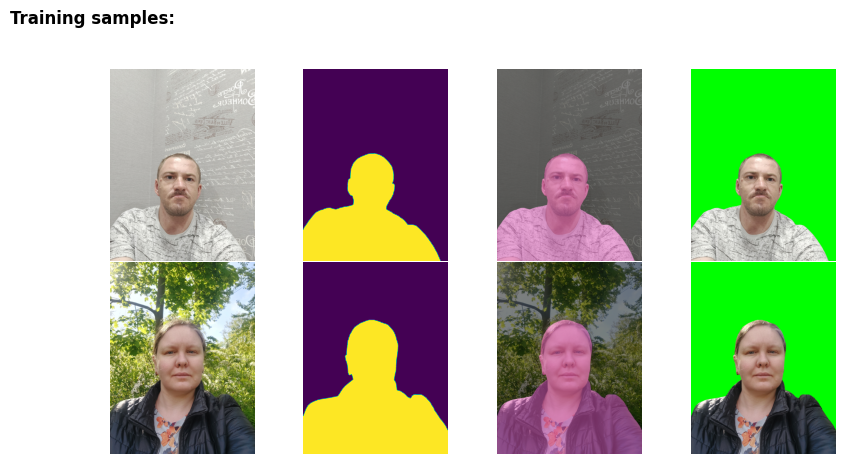

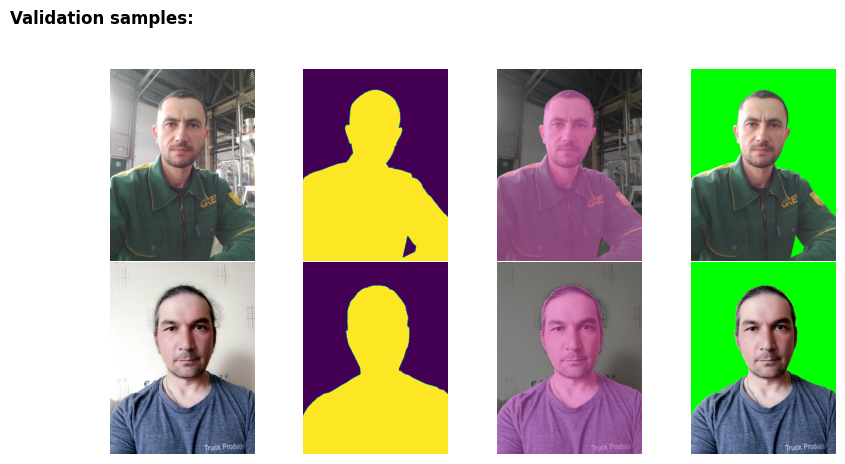

In [7]:
visualize_seg_mask([train_part[randint(0, 1000) + i] for i in range(2)],
                   main_title='Training samples:')

visualize_seg_mask([val_part[randint(0, 1000) + i] for i in range(2)],
                   main_title='Validation samples:')

## Create augmentations

In [8]:
def post_augmentation():
    post_transforms = [
        albu.Normalize(),
        albu_pytorch.transforms.ToTensorV2()  
    ]
    return albu.Compose(post_transforms)


def get_training_augmentation():
    train_transforms = [
        albu.ShiftScaleRotate(rotate_limit=25, border_mode=0, p=0.5),
        albu.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0, value = 0),
        albu.Resize(height=512, width=512, p=1),
        albu.GaussNoise(p=0.3),

        albu.OneOf(
            [
                albu.CLAHE(p=0.5),
                albu.RandomBrightnessContrast(p=0.6),
                albu.RandomGamma(p=0.4),
            ],
            p=0.6,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=0.5),
                albu.Blur(blur_limit=3, p=0.4),
                albu.MotionBlur(blur_limit=3, p=0.5),
            ],
            p=0.6,
        ),
        albu.HueSaturationValue(p=0.15),
        post_augmentation()
    ]
    return albu.Compose(train_transforms)


def get_val_test_augmentation():
    val_test_transforms = [
        albu.PadIfNeeded(512, 512),
        albu.Resize(height=512, width=512, p=1),
        post_augmentation()
    ]
    return albu.Compose(val_test_transforms)

In [9]:
aug_train_part = EasyPortraitDataset(IMGS_TRAIN_DIR, ANNOTATIONS_TRAIN_DIR, transform = get_training_augmentation())
aug_val_part = EasyPortraitDataset(IMGS_VAL_DIR , ANNOTATIONS_VAL_DIR, transform=get_val_test_augmentation())

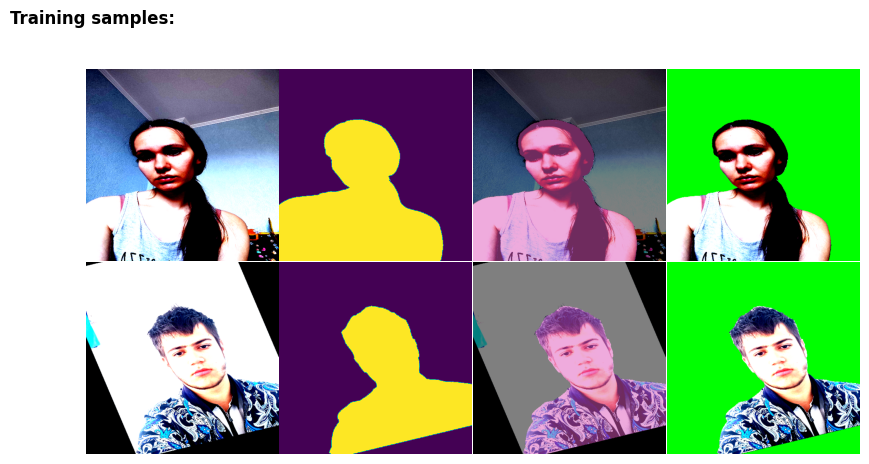

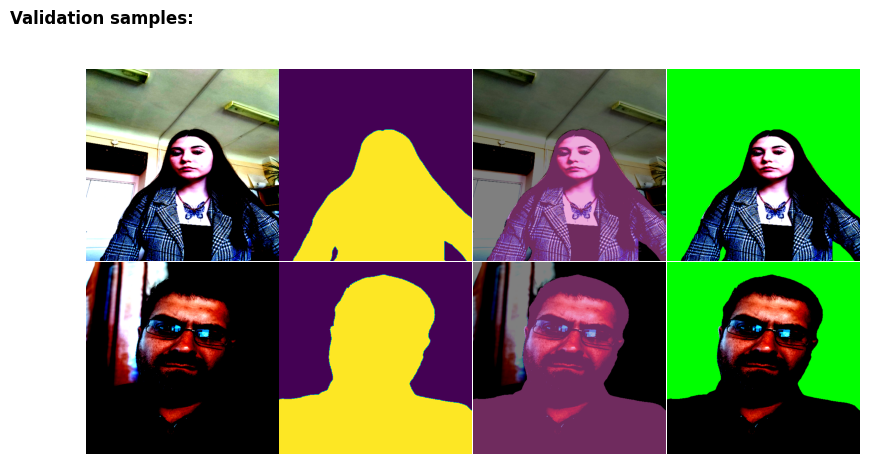

In [10]:
visualize_seg_mask([aug_train_part[randint(0, 1000) + i] for i in range(2)],
                   main_title='Training samples:')

visualize_seg_mask([aug_val_part[randint(0, 1000) + i] for i in range(2)],
                   main_title='Validation samples:')

In [11]:
train_dataset = EasyPortraitDataset(IMGS_TRAIN_DIR,
                                    ANNOTATIONS_TRAIN_DIR,
                                    get_training_augmentation())

valid_dataset = EasyPortraitDataset(IMGS_VAL_DIR,
                                    ANNOTATIONS_VAL_DIR,
                                    get_val_test_augmentation())

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=2)

In [12]:
test_dataset = EasyPortraitDataset(IMGS_TEST_DIR,
                                    ANNOTATIONS_TEST_DIR,
                                    get_val_test_augmentation())
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)

## Model creation

In [13]:
DECODER_NAME = 'deeplabv3plus'
ENCODER_NAME = 'mobileone_s4'

model = smp.create_model(DECODER_NAME,
                         encoder_name=ENCODER_NAME,
                         encoder_weights="imagenet",
                         in_channels=3,
                         classes=2)
model = model.to(device)

Downloading: "https://docs-assets.developer.apple.com/ml-research/datasets/mobileone/mobileone_s4_unfused.pth.tar" to /root/.cache/torch/hub/checkpoints/mobileone_s4_unfused.pth.tar
100%|██████████| 57.7M/57.7M [00:00<00:00, 80.0MB/s]


## Create loss function

In [14]:
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=1.0, ce_weight=1.0, lovasz_weight=1.0):
        super(CombinedLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='multiclass')
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight

    def forward(self, preds, targets):
        dice = self.dice_loss(preds, targets)
        
        ce = self.ce_loss(preds, targets)
        
        return self.dice_weight * dice + self.ce_weight * ce

criterion = CombinedLoss()

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-04, weight_decay=1e-5)

## Making training functions

In [16]:
scaler = GradScaler()

def train_epoch(model, loader, optimizer, loss_fn, device, classes):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    for images, masks in progress_bar:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        with autocast():  # Use mixed precision
            outputs = model(images)
            loss = loss_fn(outputs, masks.long())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(outputs, 1).unsqueeze(1),
                                               masks.long().unsqueeze(1),
                                               mode='multiclass',
                                               num_classes=classes)
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return epoch_loss / len(loader), iou
    
def validate_epoch(model, loader, loss_fn, device, classes):
    model.eval()
    val_loss = 0
    progress_bar = tqdm(loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)
            with autocast():  # Use mixed precision
                outputs = model(images)
                loss = loss_fn(outputs, masks.long())
            val_loss += loss.item()
            
            tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(outputs, 1).unsqueeze(1),
                                                   masks.long().unsqueeze(1),
                                                   mode='multiclass',
                                                   num_classes=classes)
            iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
            progress_bar.set_postfix({"val_loss": f"{loss.item():.4f}"})
    
    return val_loss / len(loader), iou


In [17]:
def plot_progress(model, loader, device, num=2):
    model.eval()
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs_masks = torch.argmax(outputs, 1)
            
            data_for_visualization = [(images[i].cpu(), outputs_masks[i].cpu()) for i in range(num)]
            
            visualize_seg_mask(data_for_visualization, main_title='Validation samples with predicted masks')
            break

In [18]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

## Training model

Epoch 1/1, Train Loss: 0.1118, Val Loss: 0.0435, Train IOU: 0.9805037975311279, Val IOU: 0.9579219818115234


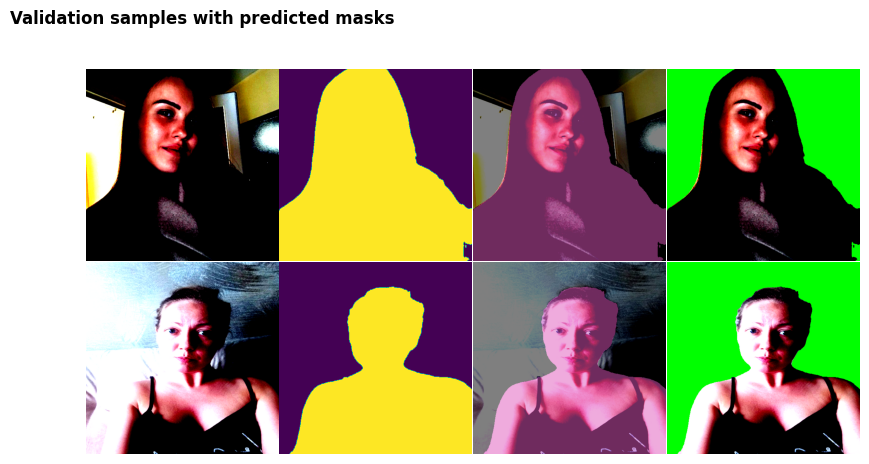

In [19]:
num_epochs = 1
for epoch in np.arange(num_epochs):
    train_loss, train_iou = train_epoch(model, train_dataloader, optimizer, criterion, device, 2)
    val_loss, val_iou = validate_epoch(model, val_dataloader, criterion, device, 2)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train IOU: {train_iou}, Val IOU: {val_iou}")
    scheduler.step(val_loss)
    plot_progress(model, val_dataloader, device)
    if (epoch + 1) % 5 == 0:
        torch.save(model, f'full_model_epoch{epoch + 1}.pth')
        print(f"Model saved: full_model_epoch{epoch + 1}.pth")

In [20]:
model = torch.load("/kaggle/input/deeplabv3plus_mobileone_s4/pytorch/default/1/deeplabplus_mobile0nes4_epoch10_binary.pth")
model = model.to(device)

## Testing

In [22]:
test_loss, test_iou = validate_epoch(model, test_dataloader, criterion, device, 2)

In [28]:
print("Test_loss: ", test_loss)
print("Test_IoU: ", test_iou.item())

Test_loss:  0.0367435259250924
Test_IoU:  0.9863648414611816


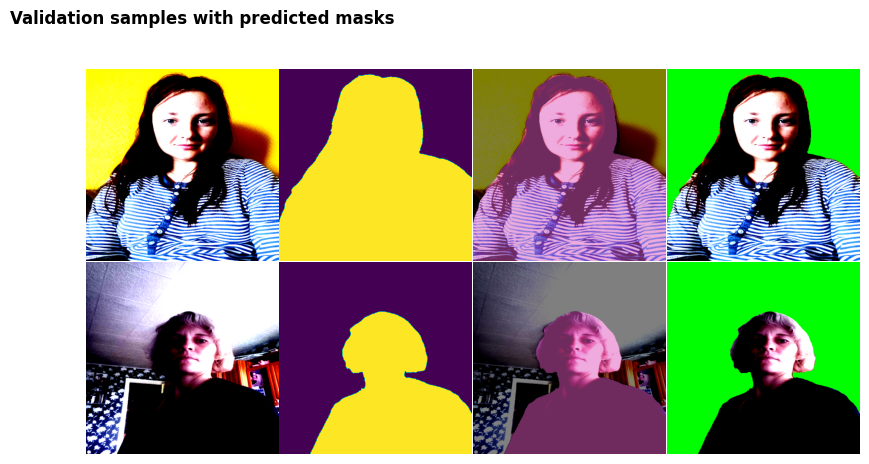

In [24]:
plot_progress(model, test_dataloader, device)